In [1]:

"""
2D Poisson Equation
    Spatial: Iterative solvers (FFT/FST)
"""
import sys
import numpy as np
import scipy
from numba import jit,njit,float64,int64

import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import scipy.sparse
import numpy.linalg
from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize, linewidth=np.inf)


In [2]:
@njit(float64(float64[:,:]))
def rms(a):
    return np.sqrt(np.mean(a**2))


In [3]:
@njit
def GaussSeidelPoisson(fA, dX, dY, mA, nA, Nx, Ny, uIni):
    tol=1e-10
    maxIter=100000
    d = -2/dX**2 -2/dY**2
    u = uIni*1
    r = fA*0
    relError = tol+1
    for numIter in range(maxIter):
        if (numIter%5000==0):
            print(numIter, relError)
        for i in np.arange(1,Nx-1):
            for j in np.arange(1,Ny-1):
                r[i,j] = fA[i,j] - (u[i+1,j]+u[i-1,j] - 2*u[i,j])/dX**2 - (u[i,j+1]+u[i,j-1] - 2*u[i,j])/dY**2
                u[i,j] = u[i,j]+r[i,j]/d
        relError = rms(r)/np.abs(d)
        if relError<tol:
            break
    #print("The solution stops at error = {relError:.3e}, steps = {iter:5d}")
    print(numIter, relError)
    return u


In [4]:
@njit
def ConjugateGradientPoisson(fA, dX, dY, mA, nA, Nx, Ny, uIni):
    tol=1e-12
    eps = 1e-16
    maxIter=100000
    d = -2/dX**2 -2/dY**2

    u = uIni*1
    r = fA*0
    r[1:Nx-1,1:Ny-1] = fA[1:Nx-1,1:Ny-1] - (u[2:Nx,1:Ny-1]+u[0:Nx-2,1:Ny-1]-2*u[1:Nx-1,1:Ny-1])/dX**2 - (u[1:Nx-1,2:Ny]+u[1:Nx-1,0:Ny-2]-2*u[1:Nx-1,1:Ny-1])/dY**2
    p = r*1 # setting the boundary condition of p will let residual blow up
    q = r*0
    relError = tol+1
    for numIter in range(maxIter):
        if (numIter%50==0):
            print(numIter, relError)

        # q = Ap
        q[1:Nx-1,1:Ny-1] = (p[2:Nx,1:Ny-1]+p[0:Nx-2,1:Ny-1]-2*p[1:Nx-1,1:Ny-1])/dX**2 + (p[1:Nx-1,2:Ny]+p[1:Nx-1,0:Ny-2]-2*p[1:Nx-1,1:Ny-1])/dY**2

        # <r,r> <q,p>
        rho = np.sum(r[1:Nx-1,1:Ny-1]**2)
        pq = np.sum(q[1:Nx-1,1:Ny-1]*p[1:Nx-1,1:Ny-1])
        alpha = rho/(pq+eps)

        u[1:Nx-1,1:Ny-1] = u[1:Nx-1,1:Ny-1]+alpha*p[1:Nx-1,1:Ny-1]

        pq = rho
        r[1:Nx-1,1:Ny-1] = r[1:Nx-1,1:Ny-1]-alpha*q[1:Nx-1,1:Ny-1]
        rho = np.sum(r[1:Nx-1,1:Ny-1]**2)
        beta = rho/(pq+eps)

        p[1:Nx-1,1:Ny-1] = r[1:Nx-1,1:Ny-1] + beta*p[1:Nx-1,1:Ny-1]

        # r = b - Ax
        r[1:Nx-1,1:Ny-1] = fA[1:Nx-1,1:Ny-1] - (u[2:Nx,1:Ny-1]+u[0:Nx-2,1:Ny-1]-2*u[1:Nx-1,1:Ny-1])/dX**2 - (u[1:Nx-1,2:Ny]+u[1:Nx-1,0:Ny-2]-2*u[1:Nx-1,1:Ny-1])/dY**2

        relError = rms(r)/np.abs(d)

        if relError<tol:
            break

        if numIter >= (Nx-1)*(Ny-1):
            break
    #print("The solution stops at error = {relError:.3e}, steps = {iter:5d}")
    print(numIter, relError)
    return u



In [5]:
def ExactSolution(x,y):
    return (x**2-1)*(y**2-1)

def SourceTerm(x,y):
    return -2*(2-x**2-y**2)

In [6]:
xMin, xMax = 0.0, 1.0
yMin, yMax = 0.0, 1.0

numXCen = 512
numYCen = 512
numXGrid = numXCen+1
numYGrid = numYCen+1

xMat, yMat = np.meshgrid(np.linspace(xMin, xMax, numXGrid), np.linspace(yMin, yMax, numYGrid), indexing="ij")
mMat, nMat = np.meshgrid(np.arange(numXGrid), np.arange(numYGrid), indexing="ij")

uExact = ExactSolution(xMat,yMat)
uBoundary = uExact*1
uBoundary[1:-1,1:-1] = 0

xArray = xMat.flatten()
yArray = yMat.flatten()
mArray = mMat.flatten()
nArray = nMat.flatten()

deltaX = xMat[1,0] - xMat[0,0]
deltaY = yMat[0,1] - yMat[0,0]

rhsF = SourceTerm(xMat, yMat)
u = ConjugateGradientPoisson(rhsF, deltaX, deltaY, mMat, nMat, numXGrid, numYGrid, uBoundary)
# u = PoissonFFTCentralDiff(rhsF, deltaX, deltaY, mMat, nMat, numXCen, numYCen)
# u[numXGrid,:] = u[0,:]
# u[:,numYGrid] = u[:,0]



0 1.000000000001
50 0.000366938332764671
100 0.00019416073379889987
150 0.0001353247931400576
200 0.00010490372631416001
250 8.510730863666861e-05
300 7.00831454074743e-05
350 5.755278880056117e-05
400 4.595454631843738e-05
450 3.546693060841834e-05
500 2.702464293913143e-05
550 2.0414728432190795e-05
600 1.5228294829561546e-05
650 1.1115621171952664e-05
700 7.823082201653603e-06
750 2.1919487569470324e-06
800 1.3871107835064396e-06
850 7.561542398428171e-07
900 4.364720170756812e-07
950 2.3738018455330564e-07
1000 1.4790035418920475e-07
1050 8.491332337062878e-08
1100 4.4376859342312245e-08
1150 2.2808272563289733e-08
1200 1.0545630585639238e-08
1250 4.45232283135064e-09
1300 1.5692156462340294e-09
1350 4.977627715322202e-10
1400 2.2591624675856352e-10
1450 9.602674128682832e-11
1500 4.1158477323952876e-11
1550 1.6759621343990017e-11
1600 6.099109801686209e-12
1650 2.2590040023125214e-12
1692 9.988944584779085e-13


3.515344859321078e-10


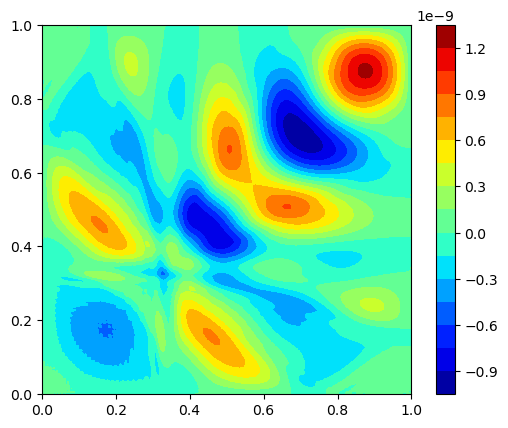

In [7]:
fig,ax = plt.subplots()
cs = ax.contourf(xMat, yMat, u-uExact, 20, cmap=cm.get_cmap('jet'))
ax.set_xlim((xMin,xMax))
ax.set_ylim((yMin,yMax))
ax.set_aspect("equal")
cbar = fig.colorbar(cs)


print(rms(u-uExact))
